In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
import pickle

sns.set()
warnings.filterwarnings('ignore')

In [2]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_percentage_error, mean_squared_error, roc_auc_score, log_loss, precision_recall_fscore_support, mean_absolute_error, roc_curve, auc, f1_score, make_scorer, precision_score, recall_score, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from imblearn.over_sampling import RandomOverSampler, SMOTE
from eli5.sklearn import PermutationImportance
from pprint import pprint

from xgboost import XGBRegressor, XGBClassifier

---

In [3]:
pd.set_option('display.max_columns', None)

---

## Load dataset

In [4]:
path = 'dataset/cleaned_data.csv'
df = pd.read_csv(path)
df.shape

(372488, 38)

## Extra processing to remove all null entries

In [5]:
# print null percentages
print(df.isnull().mean() * 100)

BidsPortfolioManager                       0.000000
BidsApi                                    0.000000
BidsManual                                 0.000000
NewCreditCustomer                          0.000000
VerificationType                           0.000000
LanguageCode                               0.000000
Age                                        0.000000
Gender                                     0.000000
Country                                    0.000000
AppliedAmount                              0.000000
Amount                                     0.000000
Interest                                   0.000000
LoanDuration                               0.000000
MonthlyPayment                             0.000000
Education                                  0.000000
MaritalStatus                             90.192973
EmploymentStatus                          90.240223
EmploymentDurationCurrentEmployer          0.000000
OccupationArea                            90.218477
HomeOwnershi

### this Rows containing nulls should be dropped in earlier steps but i kept them fo visualizations in EDA part lets remove them now

In [6]:
# if nulls in column are more than 50% then drop the column
null_val = (df.isnull().sum() / len(df))*100
missing_features = null_val[null_val > 40].index
missing_features

Index(['MaritalStatus', 'EmploymentStatus', 'OccupationArea'], dtype='object')

In [7]:
# drop this columns
df.drop(missing_features, axis=1, inplace=True)
df.shape

(372488, 35)

In [8]:
missing_categorical = df.select_dtypes(include='object').isnull().sum()
missing_numerical = df.select_dtypes(include='number').isnull().sum()

In [9]:
print(missing_categorical)
print(missing_numerical)

VerificationType                     0
LanguageCode                         0
Gender                               0
Country                              0
Education                            0
EmploymentDurationCurrentEmployer    0
HomeOwnershipType                    0
Rating                               0
CreditScoreEsMicroL                  0
YearMonth                            0
dtype: int64
BidsPortfolioManager                       0
BidsApi                                    0
BidsManual                                 0
Age                                        0
AppliedAmount                              0
Amount                                     0
Interest                                   0
LoanDuration                               0
MonthlyPayment                             0
IncomeTotal                                0
ExistingLiabilities                        0
LiabilitiesTotal                           0
RefinanceLiabilities                       0
DebtToIncome

In [10]:
for col in missing_categorical.keys():
    df[col]= df[col].interpolate('ffill')
    df[col]= df[col].interpolate('bfill')
    
    
for col in missing_numerical.keys():
    mean=df[col].mean()
    print(mean)
    df[col].fillna(mean,inplace=True)

218.17048602908014
1.1572882884817766
162.21904889285028
40.426561392581775
2612.6051613872123
2543.2344585930286
25.77310090526407
49.66280792938296
98.77597710873167
1814.264423095509
2.4508709005390776
332.29151851871734
0.0
2.804985354227683
44.13411008089152
1046.0064051217757
455.3340661374325
2351.4341309019355
1.811496073561984
3758.0214360437612
1180.7371059457075
0.045815155379555675
0.32374734219625867


In [11]:
# save the dataset 
df.to_csv('dataset\preprocessed_2.csv', index=False)

In [12]:
print(df.shape)

(372488, 35)


---

In [13]:
X = df.copy()
y = df[['loanStatus']]

X.drop(['loanStatus'], axis=1, inplace=True)

---

In [15]:
# handle categorical variables using one hot encoding
# X = pd.get_dummies(X, drop_first=True)

# handle categorical variables using label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = le.fit_transform(X[col])
X.shape


(372488, 34)

In [16]:
X.head()

,BidsPortfolioManager,BidsApi,BidsManual,NewCreditCustomer,VerificationType,LanguageCode,Age,Gender,Country,AppliedAmount,Amount,Interest,LoanDuration,MonthlyPayment,Education,EmploymentDurationCurrentEmployer,HomeOwnershipType,IncomeTotal,ExistingLiabilities,LiabilitiesTotal,RefinanceLiabilities,DebtToIncome,FreeCash,Rating,Restructured,CreditScoreEsMicroL,PrincipalPaymentsMade,InterestAndPenaltyPaymentsMade,PrincipalBalance,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousRepaymentsBeforeLoan,PreviousEarlyRepaymentsCountBeforeLoan,YearMonth
0,11.0,0.0,88.0,False,0,3,27.0,2,0,3189.0,3189.0,35.48,60.0,115.34,4,8,5,900.0,0.0,0.00,0.0,0.00,0.00,4,False,5,721.65,1330.8600,3195.94,1.0,3402.0,1161.57,0.0,162
1,0.0,0.0,0.0,False,0,4,35.0,2,1,4146.0,4146.0,19.86,60.0,108.17,1,8,6,3100.0,0.0,0.00,0.0,0.00,0.00,2,True,4,272.34,493.8575,5405.25,1.0,518.0,525.21,0.0,170
2,0.0,0.0,0.0,False,0,3,23.0,0,0,531.0,531.0,19.52,60.0,15.25,1,8,8,1700.0,0.0,0.00,0.0,0.00,0.00,2,False,0,5.52,5.0700,2086.07,3.0,1593.0,631.35,0.0,178
3,817.5,5.0,5.0,False,0,3,53.0,2,0,2125.0,2125.0,20.97,60.0,62.05,3,0,6,354.0,8.0,485.09,0.0,26.29,10.92,3,False,4,1026.77,1187.9100,1381.59,1.0,500.0,590.95,0.0,85
4,0.0,0.0,0.0,False,0,4,43.0,0,1,414.0,414.0,19.89,96.0,6.65,4,1,8,1200.0,0.0,0.00,0.0,0.00,0.00,4,False,0,9.05,32.9175,1947.54,5.0,11198.0,1176.22,0.0,174


In [17]:
over = RandomOverSampler(random_state=0)
smote = SMOTE()

stdscaler = StandardScaler()
scaler = MinMaxScaler()

pca = PCA(n_components=20)

---

## classification

In [18]:
def plot_roc(y_test,preds,model):
    """ 
    Plot the ROC curve  

    Parameters
    ----------
    y_test : pandas.Series
        the true values that we will predict
    preds : numpy.ndarray
        the predicted values
    model : str
        the name of the model

    Return
    ------ 
    A plot of the roc curve for the given model 
    """
    fpr, tpr, thresh = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    print('roc_auc_score for {}: '.format(model), roc_auc_score(y_test, preds))
    plt.subplots(1, figsize=(10,10))
    plt.title('ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [19]:
def plot_report(y_test, preds,targets = None):
    """ 
    Plot classification report 

    Parameters
    ----------
    y_test : pandas.Series
        the true values that we will predict
    preds : numpy.ndarray
        the predicted values
    target_names : list
        A list that contains the target classes names

    Return
    ------ 
    Classification report plot 
    """
    clf_report = classification_report(y_test,
                                       preds,
                                       target_names=targets,
                                       output_dict=True)
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,cmap="Greens")

In [20]:
rob_scaler = StandardScaler()
for col in X.columns:
    X[col] = rob_scaler.fit_transform(X[col].values.reshape(-1,1))
    
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# save the train,test data
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

train.to_csv('dataset/preprocessed_train.csv', index=False)
test.to_csv('dataset/preprocessed_test.csv', index=False)


# save sample of data
sample = train.sample(1000)
sample_test = test.sample(100)

sample.to_csv('dataset/mini_sample.csv', index=False)
sample_test.to_csv('dataset/mini_sample_test.csv', index=False)




## **train, test split**

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [22]:
y_train.value_counts()

loanStatus
0.0           176333
1.0            84408
Name: count, dtype: int64

## Logistic Regression 

In [23]:
log = LogisticRegression(C= 100, penalty= 'l2', solver='newton-cg')
log.fit(X_train, y_train)
preds = log.predict(X_test)
print('test accuracy = ', round(accuracy_score(y_test, preds)*100, 2), '%')

test accuracy =  81.62 %


roc_auc_score for Logistic Regression:  0.7648701994852706


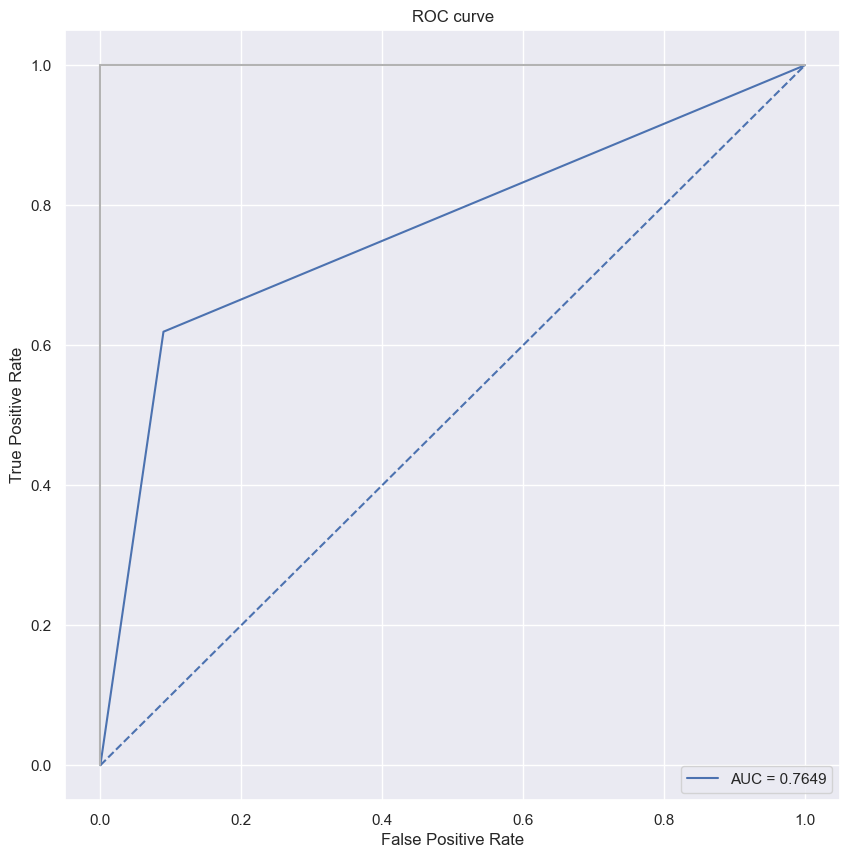

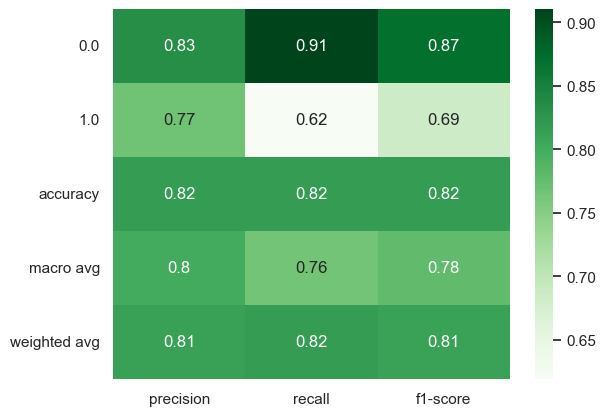

In [24]:
plot_roc(y_test, preds, 'Logistic Regression')
plot_report(y_test, preds)

## **Ensemble learning**

In [25]:
qda = QuadraticDiscriminantAnalysis()

rf = RandomForestClassifier(random_state=0)

In [26]:
estimators = [('QDA', qda), ('RandomForest', rf)]
final_estimator = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0)
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [27]:
model_ensemble = Pipeline([
    ('classifier', clf)
])

In [ ]:
model_ensemble.fit(X_train, y_train)
pred = model_ensemble.predict(X_test)
print('test accuracy = ', round(accuracy_score(y_test, pred)*100, 2), '%')

roc_auc_score for ensemble model:  0.9234669728399676


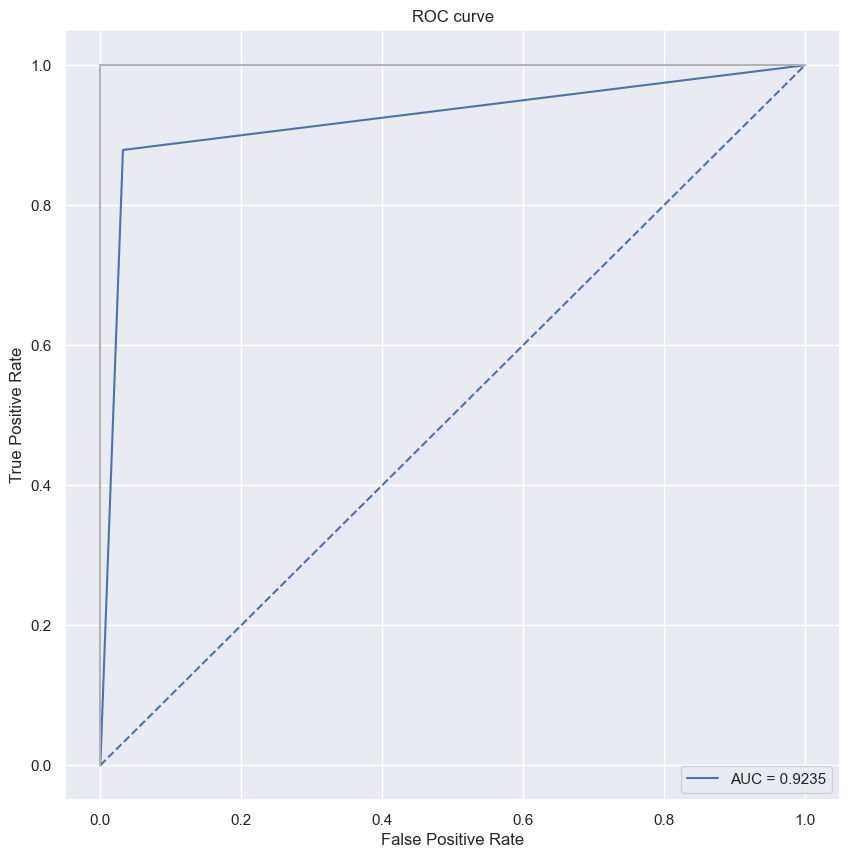

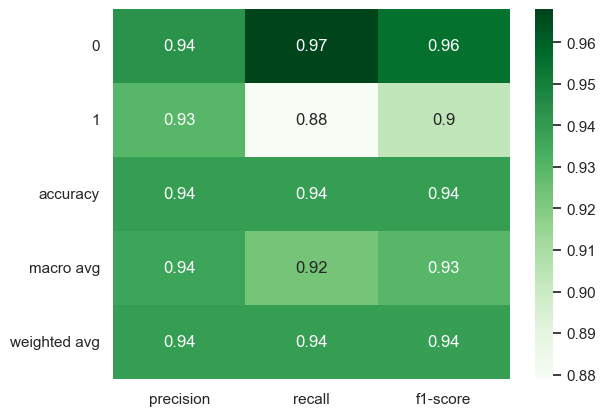

In [ ]:
plot_roc(y_test, pred, 'ensemble model')
plot_report(y_test, pred)

In [ ]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

           0      0.943     0.968     0.955     50288
           1      0.930     0.879     0.904     24221

    accuracy                          0.939     74509
   macro avg      0.936     0.923     0.930     74509
weighted avg      0.939     0.939     0.939     74509



**QDA**

In [ ]:
model_qda = Pipeline([
    ('classifier', qda)
])

In [ ]:
model_qda.fit(X_train, y_train)
pred = model_qda.predict(X_test)
print('test accuracy = ', round(accuracy_score(y_test, pred)*100, 2), '%')

test accuracy =  75.22 %


In [ ]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

           0      0.754     0.939     0.837     50288
           1      0.743     0.364     0.488     24221

    accuracy                          0.752     74509
   macro avg      0.748     0.651     0.662     74509
weighted avg      0.750     0.752     0.723     74509



**Random Forest**

In [ ]:
model_rf = Pipeline([
    ('classifier', rf)
])

In [ ]:
model_rf.fit(X_train, y_train)
pred = model_rf.predict(X_test)
print('test accuracy = ', round(accuracy_score(y_test, pred)*100, 2), '%')

test accuracy =  93.58 %


In [ ]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

           0      0.926     0.983     0.954     50288
           1      0.960     0.838     0.895     24221

    accuracy                          0.936     74509
   macro avg      0.943     0.910     0.924     74509
weighted avg      0.937     0.936     0.935     74509



---

## saving model

In [ ]:
pickle.dump(model_ensemble, open(f'models/ensemble{str(datetime.now()).replace(":", "_")}_.pkl', 'wb'))
pickle.dump(model_qda, open(f'models/qda{str(datetime.now()).replace(":", "_")}_.pkl', 'wb'))
pickle.dump(model_rf, open(f'models/rf{str(datetime.now()).replace(":", "_")}_.pkl', 'wb'))

---